# Happiness Project - Analysis

In [6]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import gmaps
import requests
import json

import statsmodels
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import linregress

In [2]:
# Import data
happiness_df = pd.read_csv("Data/Final Dataframes/happiness_df.csv")
happiness_time_final = pd.read_csv("Data/Final Dataframes/happiness_time_final.csv")
country_df = pd.read_csv("Data/Final Dataframes/country_df.csv")
weather_data = pd.read_csv("Data/Final Dataframes/weather_data.csv")
mental_health_data = pd.read_csv("Data/Final Dataframes/mental_health_data.csv")
final_covid_data = pd.read_csv("Data/Final Dataframes/final_covid_data.csv")
final_df = pd.read_csv("Data/Final Dataframes/final_df.csv")
australia_happiness = pd.read_csv("Data/Final Dataframes/australia_happiness.csv")
finland_happiness = pd.read_csv("Data/Final Dataframes/finland_happiness.csv")
afghanistan_happiness = pd.read_csv("Data/Final Dataframes/afghanistan_happiness.csv")

### Happiness by country and regions

In [50]:
# Set variable holding happiness data in time, per country
happiness_map_time = happiness_time_final[['Year', 'Country', 'Happiness Score']]
happiness_map_time = happiness_map_time.sort_values(['Year'])

# Set happiness time map parameters
fig = px.choropleth(happiness_map_time, 
                     locations="Country", 
                     locationmode = "country names",
                     color = "Happiness Score",
                     hover_name = "Country",
                     color_continuous_scale = px.colors.sequential.Plasma,
                     animation_frame = "Year",
                     category_orders={'Year': [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]})

# Show map
fig.show()

In [73]:
fig = px.histogram(final_df, x="Happiness Score")

fig.update_layout(height=600, width=800, 
                  title={'text': "<b>Histogram of Happiness Scores</b>", 
                         'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'middle'})
fig.show()

In [49]:
# Which Hemisphere is Happier? North or South?

# Create a dataframe to investigate the north/south hemisphere data
hemispheres = final_df[['Country', 'Happiness Score', 'Latitude (average)']]

# Add a 'hemisphere' column with values set according to countries latitude
for index, row in hemispheres.iterrows():
    if (hemispheres.loc[index, "Latitude (average)"] <= 0):
        hemispheres.loc[index,'hemisphere'] = "south"
    else:
        hemispheres.loc[index,'hemisphere'] = "north"

# Calculate average happiness for each hemisphere 
hemispheres_avg = hemispheres.groupby(['hemisphere']).mean().reset_index()

# Add this to a column to allow chloropleth map plotting   
for index, row in hemispheres.iterrows():
    if (hemispheres.loc[index, "Latitude (average)"] <= 0):
        hemispheres.loc[index,'avg'] = hemispheres_avg.iloc[1, 1]
    else:
        hemispheres.loc[index,'avg'] = hemispheres_avg.iloc[0, 1]

south = hemispheres[hemispheres['hemisphere'] == 'south']
north = hemispheres[hemispheres['hemisphere'] == 'north']

# Calculate p-val of northern vs southern hemisphere happinesss
p_val = round((stats.ttest_ind(south['Happiness Score'], north['Happiness Score'], equal_var=False)[1]),4)

# Plot the Chloropleth map
fig = px.choropleth(hemispheres, 
                     locations="Country", 
                     locationmode = "country names",
                     color = "avg",
                     hover_name = "Country",
                     color_continuous_scale = px.colors.sequential.Cividis_r,
                     labels={"avg":"Happiness<br>Score"})

# Formatting and text annotation of T-test results 
fig.update_layout(geo=dict(showcoastlines=False, projection_type="natural earth"),
                  annotations = [dict(x=0.5, y=1.063, xref='paper', yref='paper', 
                                      text='<b>Which Hemisphere is Happier? North or South?</b>', font=dict(size=14),showarrow= False),
                                 dict(x=0.5, y=0.2, xref='paper', yref='paper', 
                                      text='<b>Mean Happiness Scores</b>', font=dict(size=14),showarrow= False),
                                 dict(x=0.5, y=0.15, xref='paper', yref='paper', 
                                      text=f'<b>Northern Hemisphere:</b> {round((hemispheres_avg.iloc[0, 1]),2)}', font=dict(size=14),showarrow= False),
                                 dict(x=0.5, y=0.1, xref='paper', yref='paper', 
                                      text=f'<b>Southern Hemisphere:</b> {round((hemispheres_avg.iloc[1, 1]),2)}', font=dict(size=14),showarrow= False), 
                                 dict(x=0.5, y=0.05, xref='paper', yref='paper', text=f'<b>P-Value (t-test):</b> {p_val}', 
                                      font=dict(size=14),showarrow= False)])

fig

### Happiness by country over time


In [16]:
# Global average scores per year
avg_scores = happiness_time_final.groupby(['Country']).mean().sort_values(by="Happiness Score").reset_index()
avg_scores.drop('Year', axis=1)

,Country,Happiness Score,GDP per Capita,Social Support,Life Expectancy,Freedom,Generosity,Corruption
0,South Sudan,3.402000,NaN,0.554750,50.410000,0.493750,NaN,0.749500
1,Afghanistan,3.512231,7.654231,0.504923,52.284077,0.507692,0.056846,0.849538
2,Central African Republic,3.515000,6.961000,0.402400,43.356000,0.680400,0.027000,0.842000
3,Burundi,3.586000,6.707833,0.429833,51.330000,0.480000,-0.034500,0.711500
4,Togo,3.610200,7.251500,0.467300,53.045400,0.622900,-0.024500,0.800100
...,...,...,...,...,...,...,...,...
161,Netherlands,7.466133,10.889800,0.934067,71.753333,0.907800,0.269143,0.409800
162,Norway,7.501455,11.040364,0.950818,72.727273,0.954909,0.132182,0.337455
163,Switzerland,7.550364,11.097364,0.943455,73.430909,0.924182,0.099000,0.304636
164,Finland,7.614643,10.751714,0.949357,71.238571,0.940357,-0.004143,0.244500


In [55]:
time = happiness_time_final.groupby(['Region', 'Year']).mean().reset_index()
time

,Region,Year,Happiness Score,GDP per Capita,Social Support,Life Expectancy,Freedom,Generosity,Corruption
0,Central and Eastern Europe,2005,5.567250,10.001250,0.902250,65.475000,0.786000,NaN,0.936000
1,Central and Eastern Europe,2006,5.422200,10.153200,0.922800,65.032000,0.687000,-0.159000,0.871000
2,Central and Eastern Europe,2007,5.152267,9.797400,0.854467,65.421071,0.578733,-0.097467,0.901667
3,Central and Eastern Europe,2008,5.418250,9.897500,0.889250,64.493333,0.631000,-0.147250,0.849750
4,Central and Eastern Europe,2009,5.180000,9.790929,0.838714,66.036077,0.546429,-0.111071,0.906429
...,...,...,...,...,...,...,...,...,...
162,Western Europe,2017,6.891900,10.831000,0.915100,72.650000,0.855000,0.087900,0.519100
163,Western Europe,2018,6.898050,10.845474,0.911800,72.810526,0.847000,-0.002053,0.519850
164,Western Europe,2019,6.940905,10.860750,0.913762,72.990000,0.860571,-0.002316,0.533476
165,Western Europe,2020,6.919421,10.766471,0.919316,73.189474,0.864368,-0.033294,0.509789


In [57]:
global_avg = happiness_time_final.groupby(['Year']).mean().reset_index()
global_avg

,Year,Happiness Score,GDP per Capita,Social Support,Life Expectancy,Freedom,Generosity,Corruption
0,2005,6.446259,10.118667,0.897407,67.007407,0.829520,0.256000,0.715880
1,2006,5.196899,9.044284,0.835809,60.147500,0.730477,0.006654,0.755747
2,2007,5.418275,9.172951,0.807770,61.305267,0.687337,0.014833,0.792133
3,2008,5.418509,9.167273,0.784391,61.249954,0.688355,0.021486,0.764121
4,2009,5.457667,9.263805,0.819071,62.418928,0.687402,-0.005372,0.763387
5,2010,5.496806,9.393846,0.831867,63.069025,0.708262,0.003382,0.757235
6,2011,5.424082,9.286848,0.802800,62.212121,0.732186,-0.014438,0.755203
7,2012,5.443754,9.390593,0.809063,63.216993,0.711241,-0.002060,0.757955
8,2013,5.394562,9.373235,0.806555,63.326481,0.727897,-0.000158,0.763492
9,2014,5.389021,9.370972,0.805641,63.295950,0.734457,0.020261,0.738331


In [71]:
region_time_avg = happiness_time_final.groupby(['Region', 'Year']).mean().reset_index()

# Collate each Region/Country's Data
global_avg = happiness_time_final.groupby(['Year']).mean().reset_index()
aus_data = happiness_time_final[happiness_time_final['Country'] == 'Australia']
ce_europe = region_time_avg[region_time_avg['Region'] == 'Central and Eastern Europe']
w_europe = region_time_avg[region_time_avg['Region'] == 'Western Europe']
comm = region_time_avg[region_time_avg['Region'] == 'Commonwealth of Independent States']
e_esia = region_time_avg[region_time_avg['Region'] == 'East Asia']
s_asia = region_time_avg[region_time_avg['Region'] == 'South Asia']
se_asia = region_time_avg[region_time_avg['Region'] == 'Southeast Asia']
n_america = region_time_avg[region_time_avg['Region'] == 'North America and ANZ']
l_america = region_time_avg[region_time_avg['Region'] == 'Latin America and Caribbean']
ss_africa = region_time_avg[region_time_avg['Region'] == 'Sub-Saharan Africa']
mid_east = region_time_avg[region_time_avg['Region'] == 'Middle East and North Africa']

# Plot the Data
fig = make_subplots(rows=1, cols=2, specs = [[{}, {}]], horizontal_spacing = 0.05)

# Left side of plot
fig.add_trace(go.Scatter(name="Western Europe", x=w_europe["Year"], y=w_europe["Happiness Score"], mode='lines'),
              row=1, col=1)
fig.add_trace(go.Scatter(name="Central & Eastern Europe", x=ce_europe["Year"], y=ce_europe["Happiness Score"], mode='lines'), 
              row=1, col=1)
fig.add_trace(go.Scatter(name="N. America + AusNZ", x=n_america["Year"], y=n_america["Happiness Score"], mode='lines'),
              row=1, col=1)
fig.add_trace(go.Scatter(name="Latin America & Caribbean", x=l_america["Year"], y=l_america["Happiness Score"], mode='lines'),
              row=1, col=1)
fig.add_trace(go.Scatter(name="Comm. Ind States", x=comm["Year"], y=comm["Happiness Score"], mode='lines'),
              row=1, col=1)
fig.add_trace(go.Scatter(name="East Asia", x=e_esia["Year"], y=e_esia["Happiness Score"], mode='lines'),
              row=1, col=1)
fig.add_trace(go.Scatter(name="South Asia", x=s_asia["Year"], y=s_asia["Happiness Score"], mode='lines'),
              row=1, col=1)
fig.add_trace(go.Scatter(name="Southeast Asia", x=se_asia["Year"], y=se_asia["Happiness Score"], mode='lines'),
              row=1, col=1)
fig.add_trace(go.Scatter(name="Mid. East & Nth Africa", x=ss_africa["Year"], y=ss_africa["Happiness Score"], mode='lines'),
              row=1, col=1)
fig.add_trace(go.Scatter(name="Sub-Saharan Africa", x=ss_africa["Year"], y=ss_africa["Happiness Score"], mode='lines'),
              row=1, col=1)

# Right side of plot
fig.add_trace(go.Scatter(name="Australia", x=aus_data["Year"], y=aus_data["Happiness Score"], mode='lines'), 
              row=1, col=2)
fig.add_trace(go.Scatter(name="Global Average", x=global_avg["Year"], y=global_avg["Happiness Score"], mode='lines'),    
              row=1, col=2)

# Formatting and Display
fig.update_yaxes(title_text="Happiness Score", range=[3.8, 7.7], row=1, col=1)
fig.update_yaxes(title_text="", range=[3.8, 7.7], row=1, col=2)
fig.update_xaxes(title_text="Year", showgrid=False, range=[2004.5, 2021.5], row=1, col=1)
fig.update_xaxes(title_text="Year", showgrid=False, range=[2004.5, 2021.5], row=1, col=2)

fig.update_layout(height=800, width=1000, 
                  title={'text': "<b>Regional Happiness Scores over Time</b>", 
                         'y':0.9, 'x':0.42, 'xanchor': 'center', 'yanchor': 'middle'})
                                    
fig.show()

In [5]:
# Checking length of data for each year 
len_data_year = happiness_time_final.groupby(['Year']).count()

print("We have to take in consideration that not every year has the same amount of studied countries.")
print("This explains higher scores in 2005 (27 countries vs 149 in 2021). So, the year 2005 should not be considered as it is not representative enough.")

len_data_year

We have to take in consideration that not every year has the same amount of studied countries.
This explains higher scores in 2005 (27 countries vs 149 in 2021). So, the year 2005 should not be considered as it is not representative enough.


,Country,Region,Happiness Score,GDP per Capita,Social Support,Life Expectancy,Freedom,Generosity,Corruption
Year,,,,,,,,,
2005,27,27,27,27,27,27,25,1,25
2006,89,87,89,88,89,88,86,81,83
2007,102,99,102,102,100,101,101,102,98
2008,110,107,110,110,110,108,107,109,107
2009,114,108,114,113,113,111,112,113,111
2010,124,118,124,123,120,121,122,123,119
2011,146,136,146,145,145,141,145,144,138
2012,142,135,142,140,142,136,141,133,132
2013,137,132,137,136,137,133,136,133,130


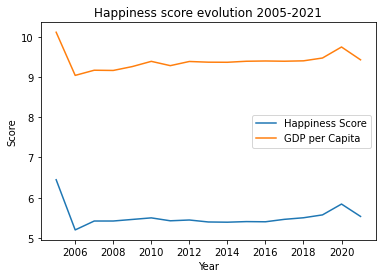

Money can not buy happiness... Really?


In [6]:
# Plot line for Happiness and GDP per Capita scores 2005-2021
plt.plot(avg_scores.index, avg_scores['Happiness Score'])
plt.plot(avg_scores.index, avg_scores['GDP per Capita'])
plt.legend(('Happiness Score','GDP per Capita'))
plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Happiness score evolution 2005-2021')
plt.show()

print("Money can not buy happiness... Really?")

### Weather and Happiness
Does better weather make you happier?

In [60]:
# AVERAGE TEMP AND HAPPINESS

# Scatter plot with linear regression
fig = px.scatter(weather_data, x="Happiness Score", y="Average Temp",  
                 hover_name="Country", color="Region", range_y=(-10,35),
                 width=1000, height=600,
                 )

# Format titles and axes
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), title_font_family="Arial", 
                  title={'text': "<b>Happiness vs Average Temperature<b>", 'y':1, 'x':0.39, 'xanchor': 'center', 'yanchor': 'top'})
fig.update_xaxes(title="Happiness Score", showgrid=True)
fig.update_yaxes(title="Average Temp 1991-2016 (deg Celsius)", showgrid=True)
fig.update_traces(marker=dict(size=10, opacity=0.8), selector=dict(mode='markers')) # formatting of dots

# LINEAR REGRESSION
# remove any nan/blanks and set the x and y params for linear regression calculation
clean = weather_data.dropna(subset=["Average Temp"])
y = clean["Average Temp"]
x = clean["Happiness Score"]

# Create the linear regression model and get values for regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
reg_line = [(x*slope)+intercept for x in weather_data["Happiness Score"]]

# Create text for regression paramaters
alpha = round(slope,1)
beta = round(intercept,1)
r = round(rvalue, 3)
if pvalue<0.0001:
    p="<0.0001"
else:
    p = round(pvalue, 4)
line1 = 'y = ' + str(alpha) + 'x' + ' + ' + str(beta)
line2 = 'r = ' + str(r)
line3 = 'p = ' + str(p)
summary = line1 + '<br>' + line2  + '<br>' + line3

# add linear regression line for whole sample
fig.add_traces(go.Scatter(x=weather_data["Happiness Score"], y=reg_line,
                          mode = 'lines',
                          marker_color='gray',
                          name='Regression line',
                          opacity=0.8,
                          showlegend=False)
               )
# Add to the equation and r squared 
fig.add_annotation(x=3.5, y=2, xref="x", yref="y", text=summary,
                   font=dict(family="Courier New, monospace", size=18, color="#ffffff"),
                   showarrow=False, align="left",
                   borderwidth=2, borderpad=4, bgcolor="rgba(100,100,100, 0.6)",
                   opacity=0.8)

# Highlight Australia on the plot
data = weather_data[weather_data['Country'] == 'Australia']
fig.add_trace(go.Scatter(
    x=[data.iloc[0,2]],
    y=[data.iloc[0,4]],
    mode="markers+text",
    name="Australia",
    text=["Australia"],
    textposition="top center",
    showlegend=False))

fig

In [56]:
# RAINFALL AND HAPPINESS

# Scatter plot with linear regression
fig = px.scatter(weather_data, x="Happiness Score", y="Average Rainfall",  
                 hover_name="Country", color="Region", range_y=(0,270),
                 width=1000, height=600,
                 )
                 

# Format titles and axes
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), title_font_family="Arial", 
                  title={'text': "<b>Happiness vs Average Rainfall<b>", 'y':1, 'x':0.38, 'xanchor': 'center', 'yanchor': 'top'})
fig.update_xaxes(title="Happiness Score", showgrid=True)
fig.update_yaxes(title="Average Rainfall (mm) 1991-2016 ", showgrid=True)
fig.update_traces(marker=dict(size=10, opacity=0.8), selector=dict(mode='markers')) # formatting of dots

# LINEAR REGRESSION
# remove any nan/blanks and set the x and y params for linear regression calculation
clean = weather_data.dropna(subset=["Average Rainfall"])
y = clean["Average Rainfall"]
x = clean["Happiness Score"]

# Create the linear regression model and get values for regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
reg_line = [(x*slope)+intercept for x in weather_data["Happiness Score"]]

# Create text for regression paramaters
alpha = round(slope,1)
beta = round(intercept,1)
r = round(rvalue, 3)
if pvalue<0.0001:
    p="<0.0001"
else:
    p = round(pvalue, 4)
line1 = 'y = ' + str(alpha) + 'x' + ' + ' + str(beta)
line2 = 'r = ' + str(r)
line3 = 'p = ' + str(p)
summary = line1 + '<br>' + line2  + '<br>' + line3

# Add linear regression line for whole sample
fig.add_traces(go.Scatter(x=weather_data["Happiness Score"], y=reg_line,
                          mode = 'lines',
                          marker_color='gray',
                          name='Regression line',
                          opacity=0.8,
                          showlegend=False)
               )
# Add to the equation and r squared 
fig.add_annotation(x=3.3, y=230, xref="x", yref="y", text=summary,
                   font=dict(family="Courier New, monospace", size=18, color="#ffffff"),
                   showarrow=False, align="left",
                   borderwidth=2, borderpad=4, bgcolor="rgba(100,100,100, 0.6)",
                   opacity=0.8)

# Highlight Australia on the plot
data = weather_data[weather_data['Country'] == 'Australia']
fig.add_trace(go.Scatter(
    x=[data.iloc[0,2]],
    y=[data.iloc[0,5]],
    mode="markers+text",
    name="Australia",
    text=["Australia"],
    textposition="top center",
    showlegend=False))

fig

In [33]:
# SUNLIGHT AND HAPPINESS

# Scatter plot with linear regression
fig = px.scatter(weather_data, x="Happiness Score", y="Sunlight",  
                 hover_name="Country", color="Region", range_y=(500,4000),
                 width=1000, height=600,
                 )
                 

# Format titles and axes
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), title_font_family="Arial", 
                  title={'text': "<b>Happiness vs Sunlight Hours</b>", 'y':0.99, 'x':0.39, 'xanchor': 'center', 'yanchor': 'top'})
fig.update_xaxes(title="Happiness Score", showgrid=True)
fig.update_yaxes(title="Annual Sunlight Hours (hr) 1991-2016 ", showgrid=True)
fig.update_traces(marker=dict(size=10, opacity=0.8), selector=dict(mode='markers')) # formatting of dots

# LINEAR REGRESSION
# remove any nan/blanks and set the x and y params for linear regression calculation
clean = weather_data.dropna(subset=["Sunlight"])
y = clean["Sunlight"]
x = clean["Happiness Score"]

# Create the linear regression model and get values for regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
reg_line = [(x*slope)+intercept for x in weather_data["Happiness Score"]]

# Create text for regression paramaters
alpha = round(slope,1)
beta = round(intercept,1)
r = round(rvalue, 3)
if pvalue<0.0001:
    p="<0.0001"
else:
    p = round(pvalue, 4)
line1 = 'y = ' + str(alpha) + 'x' + ' + ' + str(beta)
line2 = 'r = ' + str(r)
line3 = 'p = ' + str(p)
summary = line1 + '<br>' + line2  + '<br>' + line3

# Add linear regression line for whole sample
fig.add_traces(go.Scatter(x=weather_data["Happiness Score"], y=reg_line,
                          mode = 'lines',
                          marker_color='gray',
                          name='Regression line',
                          opacity=0.8,
                          showlegend=False)
               )
# Add to the equation and r squared 
fig.add_annotation(x=3.5, y=1200, xref="x", yref="y", text=summary,
                   font=dict(family="Courier New, monospace", size=18, color="#ffffff"),
                   showarrow=False, align="left",
                   borderwidth=2, borderpad=4, bgcolor="rgba(100,100,100, 0.6)",
                   opacity=0.8)

# Highlight Australia on the plot
data = weather_data[weather_data['Country'] == 'Australia']
fig.add_trace(go.Scatter(
    x=[data.iloc[0,2]],
    y=[data.iloc[0,6]],
    mode="markers+text",
    name="Australia",
    text=["Australia"],
    textposition="top center",
    showlegend=False))

fig

In [99]:
# SUNLIGHT AND GDP

# Scatter plot with linear regression
fig = px.scatter(final_df, x="GDP per Capita", y="Sunlight",  
                 hover_name="Country", color="Region", range_x=(6,12), range_y=(500,4000),
                 width=1000, height=600,
                 )
                 

# Format titles and axes
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), title_font_family="Arial", 
                  title={'text': "<b>GDP per Capita vs Sunlight Hours</b>", 'y':0.99, 'x':0.39, 'xanchor': 'center', 'yanchor': 'top'})
fig.update_xaxes(title="GDP per Capita", showgrid=True)
fig.update_yaxes(title="Annual Sunlight Hours (hr) 1991-2016 ", showgrid=True)
fig.update_traces(marker=dict(size=10, opacity=0.8), selector=dict(mode='markers')) # formatting of dots

# LINEAR REGRESSION
# remove any nan/blanks and set the x and y params for linear regression calculation
clean = final_df.dropna(subset=["Sunlight"])
y = clean["Sunlight"]
x = clean["GDP per Capita"]

# Create the linear regression model and get values for regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
reg_line = [(x*slope)+intercept for x in final_df["GDP per Capita"]]

# Create text for regression paramaters
alpha = round(slope,1)
beta = round(intercept,1)
r = round(rvalue, 3)
if pvalue<0.0001:
    p="<0.0001"
else:
    p = round(pvalue, 4)
line1 = 'y = ' + str(alpha) + 'x' + ' + ' + str(beta)
line2 = 'r = ' + str(r)
line3 = 'p = ' + str(p)
summary = line1 + '<br>' + line2  + '<br>' + line3

# Add linear regression line for whole sample
fig.add_traces(go.Scatter(x=final_df["GDP per Capita"], y=reg_line,
                          mode = 'lines',
                          marker_color='gray',
                          name='Regression line',
                          opacity=0.8,
                          showlegend=False)
               )
# Add to the equation and r squared 
fig.add_annotation(x=7.5, y=1200, xref="x", yref="y", text=summary,
                   font=dict(family="Courier New, monospace", size=18, color="#ffffff"),
                   showarrow=False, align="left",
                   borderwidth=2, borderpad=4, bgcolor="rgba(100,100,100, 0.6)",
                   opacity=0.8)

# Highlight Australia on the plot
data = final_df[final_df['Country'] == 'Australia']
fig.add_trace(go.Scatter(
    x=[data.iloc[0,4]],
    y=[data.iloc[0,12]],
    mode="markers+text",
    name="Australia",
    text=["Australia"],
    textposition="top center",
    showlegend=False))

fig

### Mental Health and Happiness
What is the influence of a country's happinesss on their rates of depression and anxiety?

In [68]:
# DEPRESSION RATE AND HAPPINESS

fig = px.scatter(mental_health_data, x="Happiness Score", y="Depression rate",  
                 hover_name="Country", color="Region", range_y=(2.5,7),
                 size="Happiness Score", size_max=10,
                 width=1000, height=600)

# Format titles and axes
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), title_font_family="Arial", 
                  title={'text': "<b>Happiness vs Depression Rate</b>", 'y':0.99, 'x':0.39, 'xanchor': 'center', 'yanchor': 'top'})
fig.update_xaxes(title="Happiness Score", showgrid=True)
fig.update_yaxes(title="Depression Rate (%)", showgrid=True)
fig.update_traces(marker=dict(size=10, opacity=0.8), selector=dict(mode='markers')) # formatting of dots


# LINEAR REGRESSION
# remove any nan/blanks and set the x and y params for linear regression calculation
clean = mental_health_data.dropna(subset=["Depression rate"])
y = clean["Depression rate"]
x = clean["Happiness Score"]

# Create the linear regression model and get values for regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
reg_line = [(x*slope)+intercept for x in mental_health_data["Happiness Score"]]

# Create text for regression paramaters
alpha = round(slope,1)
beta = round(intercept,1)
r = round(rvalue, 3)
if pvalue<0.0001:
    p="<0.0001"
else:
    p = round(pvalue, 4)
line1 = 'y = ' + str(alpha) + 'x' + ' + ' + str(beta)
line2 = 'r = ' + str(r)
line3 = 'p = ' + str(p)
summary = line1 + '<br>' + line2  + '<br>' + line3

# add linear regression line for whole sample
fig.add_traces(go.Scatter(x=mental_health_data["Happiness Score"], y=reg_line,
                          mode = 'lines',
                          marker_color='gray',
                          name='Regression line',
                          opacity=0.8,
                          showlegend=False)
               )
# Add to the equation and r squared 
fig.add_annotation(x=3.5, y=6, xref="x", yref="y", text=summary,
                   font=dict(family="Courier New, monospace", size=18, color="#ffffff"),
                   showarrow=False, align="left",
                   borderwidth=2, borderpad=4, bgcolor="rgba(100,100,100, 0.6)",
                   opacity=0.8)

# Highlight Australia on the plot
data = mental_health_data[mental_health_data['Country'] == 'Australia']
fig.add_trace(go.Scatter(
    x=[data.iloc[0,2]],
    y=[data.iloc[0,3]],
    mode="markers+text",
    name="Australia",
    text=["Australia"],
    textposition="top center",
    showlegend=False
))


In [100]:
# ANXIETY RATE AND HAPPINESS

fig = px.scatter(mental_health_data, x="Happiness Score", y="Anxiety rate",  
                 hover_name="Country", color="Region", range_y=(1,9),
                 size="Happiness Score", size_max=10,
                 width=1000, height=600)

# Format titles and axes
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), title_font_family="Arial", 
                  title={'text': "<b>Happiness vs Anxiety Rate</b>", 'y':0.99, 'x':0.39, 'xanchor': 'center', 'yanchor': 'top'})
fig.update_xaxes(title="Happiness Score", showgrid=True)
fig.update_yaxes(title="Anxiety Rate (%)", showgrid=True)
fig.update_traces(marker=dict(size=10, opacity=0.8), selector=dict(mode='markers')) # formatting of dots


# LINEAR REGRESSION
# remove any nan/blanks and set the x and y params for linear regression calculation
clean = mental_health_data.dropna(subset=["Anxiety rate"])
y = clean["Anxiety rate"]
x = clean["Happiness Score"]

# Create the linear regression model and get values for regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
reg_line = [(x*slope)+intercept for x in mental_health_data["Happiness Score"]]

# Create text for regression paramaters
alpha = round(slope,1)
beta = round(intercept,1)
r = round(rvalue, 3)
if pvalue<0.0001:
    p="<0.0001"
else:
    p = round(pvalue, 4)
line1 = 'y = ' + str(alpha) + 'x' + ' + ' + str(beta)
line2 = 'r = ' + str(r)
line3 = 'p = ' + str(p)
summary = line1 + '<br>' + line2  + '<br>' + line3

# add linear regression line for whole sample
fig.add_traces(go.Scatter(x=mental_health_data["Happiness Score"], y=reg_line,
                          mode = 'lines',
                          marker_color='gray',
                          name='Regression line',
                          opacity=0.8,
                          showlegend=False)
               )
# Add to the equation and r squared 
fig.add_annotation(x=3.5, y=7.5, xref="x", yref="y", text=summary,
                   font=dict(family="Courier New, monospace", size=18, color="#ffffff"),
                   showarrow=False, align="left",
                   borderwidth=2, borderpad=4, bgcolor="rgba(100,100,100, 0.6)",
                   opacity=0.8)

# Highlight Australia on the plot
data = mental_health_data[mental_health_data['Country'] == 'Australia']
fig.add_trace(go.Scatter(
    x=[data.iloc[0,2]],
    y=[data.iloc[0,4]],
    mode="markers+text",
    name="Australia",
    text=["Australia"],
    textposition="top center",
    showlegend=False
))


In [10]:
# Covid and happiness

# Scatter plot with linear regression
fig = px.scatter(final_df, x="Happiness Score", y="Covid Cases per Mil Pop",  
                 hover_name="Country", trendline="ols",range_y=(-10,70),
                 width=800, height=600)
                 

# Get results from linear regression 
model = px.get_trendline_results(fig)
results = model.iloc[0]["px_fit_results"]
alpha = round(results.params[0],1)
beta = round(results.params[1],1)
r_squared = results.rsquared

# Create text for regression paramaters
line1 = 'y = ' + str(beta) + 'x' + ' + ' + str(alpha) 
line2 = 'r<sup>2</sup> = ' + str(round(r_squared, 3))
summary = line1 + '<br>' + line2 

# Add to the plot
fig.add_annotation(x=3.5, y=2, xref="x", yref="y", text=summary,
                   font=dict(family="Courier New, monospace", size=18, color="#ffffff"),
                   showarrow=False, align="left",
                   borderwidth=2, borderpad=4, bgcolor="rgba(100,100,100, 0.6)",
                   opacity=0.8)

# Format titles and axes
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), title_font_family="Arial", 
                  title={'text': "Happiness vs Covid Cases per Mil pop", 'y':1, 'x':0.55, 'xanchor': 'center', 'yanchor': 'top'})
fig.update_xaxes(title="Happiness Score", showgrid=True)
fig.update_yaxes(title="Covid Cases per Mil Pop", showgrid=True)
fig.update_traces(marker=dict(size=10, opacity=0.8), selector=dict(mode='markers')) # formatting of dots
fig.show()

In [11]:
# Covid and happiness
for index, row in final_covid_data.iterrows():
    if (final_covid_data.loc[index, "Covid Cases per Mil Pop"] == 0):
        final_covid_data.loc[index, "Covid Cases per Mil Pop"] = np.nan

test = final_covid_data.dropna(axis=0)
  
test["Covid Cases per Mil Pop"].astype(float)
test["Covid Cases per Mil Pop"].dtype
#Scatter plot with linear regression
fig = px.scatter(test, y="Happiness Score", x="Covid Cases per Mil Pop",  
                 hover_name="Country", trendline="ols", range_y=(2,9), log_x=True,
                 width=800, height=600)
                 

# Get results from linear regression 
model = px.get_trendline_results(fig)
results = model.iloc[0]["px_fit_results"]
alpha = round(results.params[0],1)
beta = round(results.params[1],1)
r_squared = results.rsquared

# Create text for regression paramaters
line1 = 'y = ' + str(beta) + 'x' + ' + ' + str(alpha) 
line2 = 'r<sup>2</sup> = ' + str(round(r_squared, 3))
summary = line1 + '<br>' + line2 

# Add to the plot
fig.add_annotation(x=3, y=3.2, xref="x", yref="y", text=summary,
                   font=dict(family="Courier New, monospace", size=18, color="#ffffff"),
                   showarrow=False, align="left",
                   borderwidth=2, borderpad=4, bgcolor="rgba(100,100,100, 0.6)",
                   opacity=0.8)

# Format titles and axes
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), title_font_family="Arial", 
                  title={'text': "Happiness vs Covid Cases per Mil pop", 'y':1, 'x':0.55, 'xanchor': 'center', 'yanchor': 'top'})
fig.update_yaxes(title="Happiness Score", showgrid=True)
fig.update_xaxes(title="Covid Cases per Mil Pop", showgrid=True)
fig.update_traces(marker=dict(size=10, opacity=0.8), selector=dict(mode='markers')) # formatting of dots
fig.show()

### COVID and Happiness

In [13]:
# Covid and happiness

# Scatter plot with linear regression
fig = px.scatter(final_df, x="Happiness Score", y="Covid Death Rate",  
                 hover_name="Country", trendline="ols",range_y=(-5,20),
                 width=800, height=600)
                 

# Get results from linear regression 
model = px.get_trendline_results(fig)
results = model.iloc[0]["px_fit_results"]
alpha = round(results.params[0],1)
beta = round(results.params[1],1)
r_squared = results.rsquared

# Create text for regression paramaters
line1 = 'y = ' + str(beta) + 'x' + ' + ' + str(alpha) 
line2 = 'r<sup>2</sup> = ' + str(round(r_squared, 3))
summary = line1 + '<br>' + line2 

# Add to the plot
fig.add_annotation(x=3.5, y=2, xref="x", yref="y", text=summary,
                   font=dict(family="Courier New, monospace", size=18, color="#ffffff"),
                   showarrow=False, align="left",
                   borderwidth=2, borderpad=4, bgcolor="rgba(100,100,100, 0.6)",
                   opacity=0.8)

# Format titles and axes
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), title_font_family="Arial", 
                  title={'text': "Happiness vs Covid Death Rate", 'y':1, 'x':0.55, 'xanchor': 'center', 'yanchor': 'top'})
fig.update_xaxes(title="Happiness Score", showgrid=True)
fig.update_yaxes(title="Covid Death Rate", showgrid=True)
fig.update_traces(marker=dict(size=10, opacity=0.8), selector=dict(mode='markers')) # formatting of dots
fig.show()

In [14]:
# Country's Happiness and Covid death rate

fig = px.scatter(final_df, x="Happiness Score", y="Covid Death Rate",  
                 hover_name="Country", color="Region", range_y=(-1,7),
                 size="Happiness Score", size_max=10,
                 width=1000, height=600)
fig

# LINEAR REGRESSION
# Set the x and y params for linear regression calculation
y = final_df["Covid Death Rate"]
x = sm.add_constant(final_df["Happiness Score"])

# Create the linear regression model and get values for regression line
model = sm.OLS(y, x, missing='drop')
results = model.fit()
reg_line = [(x*results.params[1])+results.params[0] for x in final_df["Happiness Score"]]

# Create text for regression paramaters
alpha = round(results.params[0],1)
beta = round(results.params[1],1)
r_squared = round(results.rsquared, 3)
line1 = 'y = ' + str(beta) + 'x' + ' + ' + str(alpha)
line2 = 'r<sup>2</sup> = ' + str(r_squared)
summary = line1 + '<br>' + line2 

# add linear regression line for whole sample
fig.add_traces(go.Scatter(x=final_df["Happiness Score"], y=reg_line,
                          mode = 'lines',
                          marker_color='gray',
                          name='Regression line',
                          opacity=0.8,
                          showlegend=False)
               )
# Add to the equation and r squared 
fig.add_annotation(x=3.5, y=6, xref="x", yref="y", text=summary,
                   font=dict(family="Courier New, monospace", size=18, color="#ffffff"),
                   showarrow=False, align="left",
                   borderwidth=2, borderpad=4, bgcolor="rgba(100,100,100, 0.6)",
                   opacity=0.8)

In [51]:
# Covid and depression

# Scatter plot with linear regression
fig = px.scatter(final_df, x="Depression rate", y="Covid Death Rate",  
                 hover_name="Country", trendline="ols",range_y=(-1, 10),
                 width=800, height=600)
                 

# Get results from linear regression 
model = px.get_trendline_results(fig)
results = model.iloc[0]["px_fit_results"]
alpha = round(results.params[0],1)
beta = round(results.params[1],1)
r_squared = results.rsquared

# Create text for regression paramaters
line1 = 'y = ' + str(beta) + 'x' + ' + ' + str(alpha) 
line2 = 'r<sup>2</sup> = ' + str(round(r_squared, 3))
summary = line1 + '<br>' + line2 

# Add to the plot
fig.add_annotation(x=5.5, y=8, xref="x", yref="y", text=summary,
                   font=dict(family="Courier New, monospace", size=18, color="#ffffff"),
                   showarrow=False, align="left",
                   borderwidth=2, borderpad=4, bgcolor="rgba(100,100,100, 0.6)",
                   opacity=0.8)

# Format titles and axes
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), title_font_family="Arial", 
                  title={'text': "Depression rate vs Covid Death Rate", 'y':1, 'x':0.55, 'xanchor': 'center', 'yanchor': 'top'})
fig.update_xaxes(title="Depression rate", showgrid=True)
fig.update_yaxes(title="Covid Death Rate", showgrid=True)
fig.update_traces(marker=dict(size=10, opacity=0.8), selector=dict(mode='markers')) # formatting of dots
fig.show()

In [16]:
# Covid death and GDP per Capita

fig = px.scatter(final_df, x="GDP per Capita", y="Covid Death Rate",  
                 hover_name="Country", color="Region", range_x=(6,12), range_y=(-1,7),
                 size="Happiness Score", size_max=10,
                 width=1000, height=600)
fig

# LINEAR REGRESSION
# Set the x and y params for linear regression calculation
y = final_df["Covid Death Rate"]
x = sm.add_constant(final_df["GDP per Capita"])

# Create the linear regression model and get values for regression line
model = sm.OLS(y, x, missing='drop')
results = model.fit()
reg_line = [(x*results.params[1])+results.params[0] for x in final_df["GDP per Capita"]]

# Create text for regression paramaters
alpha = round(results.params[0],1)
beta = round(results.params[1],1)
r_squared = round(results.rsquared, 3)
line1 = 'y = ' + str(beta) + 'x' + ' + ' + str(alpha)
line2 = 'r<sup>2</sup> = ' + str(r_squared)
summary = line1 + '<br>' + line2 

# add linear regression line for whole sample
fig.add_traces(go.Scatter(x=final_df["GDP per Capita"], y=reg_line,
                          mode = 'lines',
                          marker_color='gray',
                          name='Regression line',
                          opacity=0.8,
                          showlegend=False)
               )
# Add to the equation and r squared 
fig.add_annotation(x=3.5, y=6, xref="x", yref="y", text=summary,
                   font=dict(family="Courier New, monospace", size=18, color="#ffffff"),
                   showarrow=False, align="left",
                   borderwidth=2, borderpad=4, bgcolor="rgba(100,100,100, 0.6)",
                   opacity=0.8)

In [17]:
# Covid numbers and Average Temp just for fun

fig = px.scatter(final_df, x="Average Temp", y="Covid Cases",  
                 hover_name="Country", color="Region", range_y=(-50000,500000), range_x=(-5,30),
                 size="Happiness Score", size_max=10, 
                 width=1000, height=600)
fig

# LINEAR REGRESSION
# Set the x and y params for linear regression calculation
y = final_df["Covid Cases"]
x = sm.add_constant(final_df["Average Temp"])

# Create the linear regression model and get values for regression line
model = sm.OLS(y, x, missing='drop')
results = model.fit()
reg_line = [(x*results.params[1])+results.params[0] for x in final_df["Average Temp"]]

# Create text for regression paramaters
alpha = round(results.params[0],1)
beta = round(results.params[1],1)
r_squared = round(results.rsquared, 3)
line1 = 'y = ' + str(beta) + 'x' + ' + ' + str(alpha)
line2 = 'r<sup>2</sup> = ' + str(r_squared)
summary = line1 + '<br>' + line2 

# add linear regression line for whole sample
fig.add_traces(go.Scatter(x=final_df["Average Temp"], y=reg_line,
                          mode = 'lines',
                          marker_color='gray',
                          name='Regression line',
                          opacity=0.8,
                          showlegend=False)
               )
# Add to the equation and r squared 
fig.add_annotation(x=3.5, y=6, xref="x", yref="y", text=summary,
                   font=dict(family="Courier New, monospace", size=18, color="#ffffff"),
                   showarrow=False, align="left",
                   borderwidth=2, borderpad=4, bgcolor="rgba(100,100,100, 0.6)",
                   opacity=0.8)

### Things to consider;
Correlation / Causation. What makes us Happy vs. What can result from Happiness..

The r-value is 0.7897596965098932


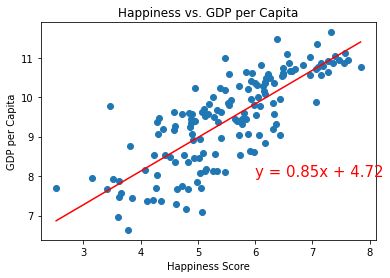

In [18]:
# Set values for x and y axis
x_axis = happiness_df['Happiness Score']
y_axis = happiness_df['GDP per Capita']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(6,8),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. GDP per Capita')
plt.xlabel('Happiness Score')
plt.ylabel('GDP per Capita')          

# Save plotted figure as .png
plt.savefig("images/Happiness_GDP_per_capita.png")

# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

The r-value is 0.7568876453635


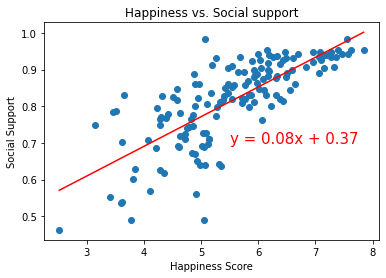

In [19]:
# Set values for x and y axis
x_axis = happiness_df['Happiness Score']
y_axis = happiness_df['Social Support']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(5.5,0.7),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. Social support')
plt.xlabel('Happiness Score')
plt.ylabel('Social Support')

# Save plotted figure as .png
plt.savefig("images/Happiness_Social_Support.png")
           
# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

The r-value is 0.7680994550105205


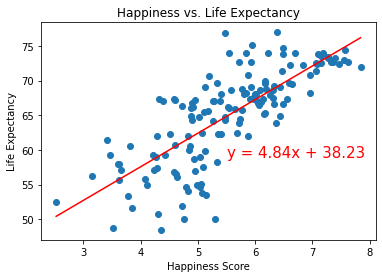

In [20]:
# Set values for x and y axis
x_axis = happiness_df['Happiness Score']
y_axis = happiness_df['Life Expectancy']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(5.5,59),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. Life Expectancy')
plt.xlabel('Happiness Score')
plt.ylabel('Life Expectancy')          

# Save plotted figure as .png
plt.savefig("images/Happiness_Life_Expectancy.png")

# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

The r-value is 0.6077530656580242


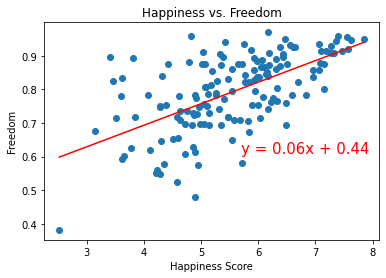

In [21]:
# Set values for x and y axis
x_axis = happiness_df['Happiness Score']
y_axis = happiness_df['Freedom']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(5.7,0.61),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. Freedom')
plt.xlabel('Happiness Score')
plt.ylabel('Freedom')          

# Save plotted figure as .png
plt.savefig("images/Happiness_Freedom.png")

# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

The r-value is -0.017799276922640793


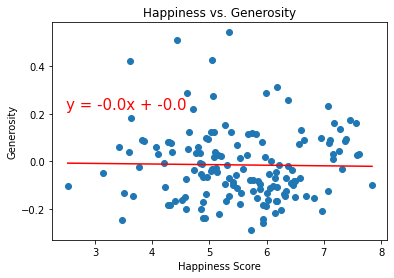

In [22]:
# Set values for x and y axis
x_axis = happiness_df['Happiness Score']
y_axis = happiness_df['Generosity']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(2.5,0.22),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. Generosity')
plt.xlabel('Happiness Score')
plt.ylabel('Generosity')          

# Save plotted figure as .png
plt.savefig("images/Happiness_Generosity.png")

# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

The r-value is -0.4211399967385784


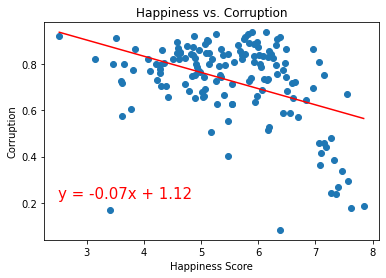

In [23]:
# Set values for x and y axis
x_axis = happiness_df['Happiness Score']
y_axis = happiness_df['Corruption']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(2.5,0.22),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. Corruption')
plt.xlabel('Happiness Score')
plt.ylabel('Corruption')          

# Save plotted figure as .png
plt.savefig("images/Happiness_Corruption.png")

# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

In [24]:
# Read in GDP per Capita .csv file
GDP_per_capita_df = pd.read_csv("Data/World_GDP_per_capita_1960-2019.csv")

# Reduce dataframe to only show 2019 GDP per Capita
GDP_per_capita_2019_df = GDP_per_capita_df[['Country Name', '2019']]

# Rename columns
GDP_per_capita_2019_df = GDP_per_capita_2019_df.rename(columns={'Country Name': 'Country',
                                                                '2019': '2019 GDP per Capita'})

# GDP_per_capita_df = GDP_per_capita_df.dropna()

# Show dataframe preview
GDP_per_capita_2019_df.head()

,Country,2019 GDP per Capita
0,Aruba,NaN
1,Afghanistan,507.103432
2,Angola,2790.726615
3,Albania,5353.244856
4,Andorra,40886.391160


In [25]:
# Read in GDP .csv file
GDP_df = pd.read_csv("Data/World_GDP_1960-2019.csv")

# Reduce dataframe to only show 2019 GDP per Capita
GDP_2019_df = GDP_df[['Country Name', '2019']]

# Rename columns
GDP_2019_df = GDP_2019_df.rename(columns={'Country Name': 'Country',
                                          '2019': '2019 GDP'})

# GDP_2019_df = GDP_2019_df.dropna()

# Show dataframe preview
GDP_2019_df.head()

,Country,2019 GDP
0,Aruba,NaN
1,Afghanistan,1.929110e+10
2,Angola,8.881570e+10
3,Albania,1.527918e+10
4,Andorra,3.154058e+09


In [26]:
# Merge happiness, 2019 GDP per Capita and 2019 GDP dataframes
happiness_GDP_2019_df = pd.merge(happiness_df, GDP_per_capita_2019_df, how='inner', on="Country") 
happiness_GDP_2019_df = pd.merge(happiness_GDP_2019_df, GDP_2019_df, how='inner', on="Country") 

# Show dataframe preview
happiness_GDP_2019_df.head()

,Country,Region,Year,Happiness Score,GDP per Capita,Social Support,Life Expectancy,Freedom,Generosity,Corruption,Alpha-2 code,2019 GDP per Capita,2019 GDP
0,Finland,Western Europe,2021,7.842,10.775,0.954,72.0,0.949,-0.098,0.186,FI,48782.78848,2.692960e+11
1,Denmark,Western Europe,2021,7.620,10.933,0.954,72.7,0.946,0.030,0.179,DK,60170.34264,3.501040e+11
2,Switzerland,Western Europe,2021,7.571,11.117,0.942,74.4,0.919,0.025,0.292,CH,81993.72713,7.030820e+11
3,Iceland,Western Europe,2021,7.554,10.878,0.983,73.0,0.955,0.160,0.673,IS,66944.83308,2.418804e+10
4,Netherlands,Western Europe,2021,7.464,10.932,0.942,72.4,0.913,0.175,0.338,NL,52331.31673,9.070510e+11


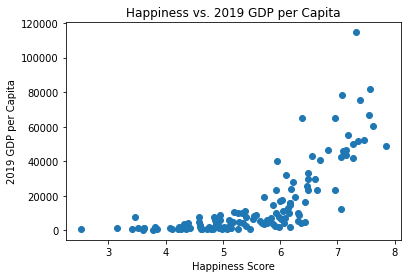

In [29]:
# Set values for x and y axis
x_axis = happiness_GDP_2019_df['Happiness Score']
y_axis = happiness_GDP_2019_df['2019 GDP per Capita']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")

# Add title and labels to line plot
plt.title('Happiness vs. 2019 GDP per Capita')
plt.xlabel('Happiness Score')
plt.ylabel('2019 GDP per Capita')          

# Save plotted figure as .png
plt.savefig("images/Happiness_2019_GDP_per_Capita.png")

# Show line plot
plt.show()

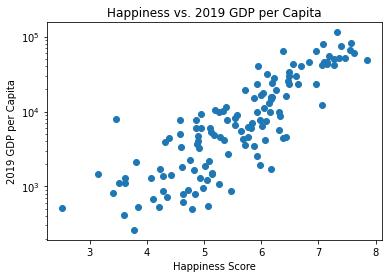

In [30]:
# Re-create previous plot but with a logarithmic scale on the y-axis
fig = plt.scatter(x_axis, y_axis)
ax = plt.gca()
ax.set_yscale('log')

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")


# Add title and labels to line plot
plt.title('Happiness vs. 2019 GDP per Capita')
plt.xlabel('Happiness Score')
plt.ylabel('2019 GDP per Capita')          

# Save plotted figure as .png
plt.savefig("images/Happiness_2019_GDP_per_Capita.png")

# Show line plot
plt.show()

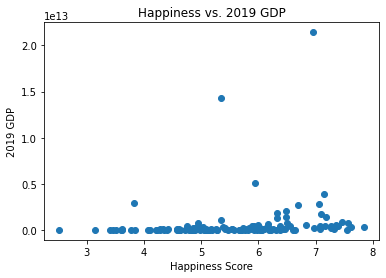

In [32]:
# Set values for x and y axis
x_axis = happiness_GDP_2019_df['Happiness Score']
y_axis = happiness_GDP_2019_df['2019 GDP']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")

# Add title and labels to line plot
plt.title('Happiness vs. 2019 GDP')
plt.xlabel('Happiness Score')
plt.ylabel('2019 GDP')          

# Save plotted figure as .png
plt.savefig("images/Happiness_2019_GDP.png")

# Show scatter plot
plt.show()

### Analysing Australia's Happiness;

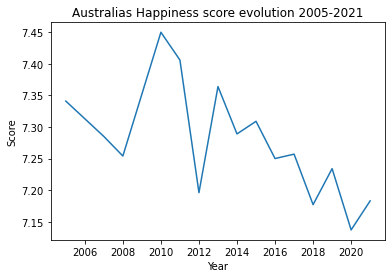

In [33]:
# Plot line for Australia's Happiness Scores 2005-2021
x_axis = australia_happiness['Year']
y_axis = australia_happiness['Happiness Score']

plt.plot(x_axis, y_axis)

plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Australias Happiness score evolution 2005-2021')

# Save plotted figure as .png
plt.savefig("images/australia_happiness.png")

# Show line plot
plt.show()

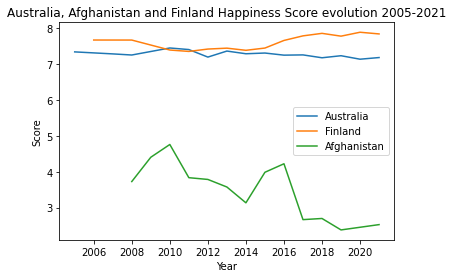

In [34]:
# Plot line for Australia, Afghanistan and Finland Happiness Scores 2005-2021
x_axis = australia_happiness['Year']
y_axis = australia_happiness['Happiness Score']
x_axis2 = finland_happiness['Year']
y_axis2 = finland_happiness['Happiness Score']
x_axis3 = afghanistan_happiness['Year']
y_axis3 = afghanistan_happiness['Happiness Score']

plt.plot(x_axis, y_axis)
plt.plot(x_axis2, y_axis2)
plt.plot(x_axis3, y_axis3)

plt.legend(('Australia','Finland', 'Afghanistan'), loc=7)
plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Australia, Afghanistan and Finland Happiness Score evolution 2005-2021')

# Save plotted figure as .png
plt.savefig("images/australia_afghanistan_finland_happiness.png")

# Show line plot
plt.show()